## Summary of the Geolocation Bias Corrections

+ Distribution of the range delay time series using `boxenplot`
+ Overall RMSE in Table

Link: https://seaborn.pydata.org/generated/seaborn.boxenplot.html

In [1]:
%matplotlib inline
import os
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt, ticker, patches
from mintpy.objects import timeseries
from mintpy.utils import readfile, utils as ut
plt.rcParams.update({'font.size': 12})

work_dir = os.path.expanduser('~/Papers/2021_Geolocation/figs_src/box_stats')
os.chdir(work_dir)
print('Go to directory:', work_dir)

Go to directory: /Users/yunjunz/Papers/2021_Geolocation/figs_src/box_stats


In [2]:
# utils func
def read_data(proj_dir, S1_bias=True, tec_type='TECjhr', print_msg=True):
    proj_name = os.path.basename(proj_dir)
    lalo = [-21.30, -67.39] if proj_name.startswith('ChileSen') else None

    suffixB = '_S1Bias' if (S1_bias and 'Sen' in proj_name) else ''
    if tec_type is None:
        suffixT = ''
    elif tec_type == 'TECsub' and proj_name == 'ChileSenAT149':
        suffixT = '_TECsub'
    else:
        suffixT = '_TECjhr'
    ### data files
    fnames = [
        os.path.join(proj_dir, 'mintpy_offset', 'timeseriesRg{}.h5'.format(suffixB)),
        os.path.join(proj_dir, 'mintpy_offset', 'timeseriesRg{}{}.h5'.format(suffixB, suffixT)),
        os.path.join(proj_dir, 'mintpy_offset', 'timeseriesRg{}{}_SET.h5'.format(suffixB, suffixT)),
        os.path.join(proj_dir, 'mintpy_offset', 'timeseriesRg{}{}_SET_ERA5.h5'.format(suffixB, suffixT)),
    ]
    fnames = [x for x in fnames if os.path.isfile(x)]
    geom_file = os.path.join(proj_dir, 'mintpy_offset', 'inputs/geometryRadar.h5')
    mask_file = os.path.join(proj_dir, 'mintpy_offset', 'maskResInv.h5')

    # date info
    date_list = timeseries(fnames[0]).get_date_list()
    num_date = len(date_list)

    # for ChileSenDT156, remove the outlier at 2015-04-02
    flag = np.ones(num_date, dtype=np.bool_)
    if proj_name == 'ChileSenDT156':
        flag[date_list.index('20150402')] = 0

    # lalo --> box
    if lalo is None:
        box = None
    else:
        atr = readfile.read_attribute(fnames[0])
        coord = ut.coordinate(atr, lookup_file=geom_file)
        y, x = coord.geo2radar(lalo[0], lalo[1])[:2]
        win = 10
        box = (x-win, y-win, x+win+1, y+win+1)

    # read data into lists
    dDict = dict()
    mask = readfile.read(mask_file, box=box)[0].flatten()
    for i, fname in enumerate(fnames):
        # label
        fbase = os.path.basename(fname).replace('timeseriesRg', 'SAR').replace('.h5', '')
        label = ' - '.join(fbase.split('_'))

        # read data
        ts_data = readfile.read(fname, box=box)[0].reshape(num_date, -1)[flag][:, mask]
        ts_med = np.nanmedian(ts_data, axis=-1)
        ts_med -= np.nanmedian(ts_med)

        # print out stats
        rmse = ut.root_mean_sq_error(ts_med) * 100
        dmin = np.nanmin(ts_med) * 100
        dmax = np.nanmax(ts_med) * 100
        if print_msg:
            if i == 0:
                print(f'{proj_name}: MIN / MAX / RMSE')
            print('    {:<35}: {:8.1f} / {:8.1f} / {:8.1f} cm'.format(label, dmin, dmax, rmse))

        # save for outputs
        if 'TECjlr' not in label:
            dDict[label] = ts_med

    return proj_name, dDict

## Read Data

For the RMSE data

In [6]:
proj_dirs = [os.path.expanduser('~/data/geolocation/ChileSenAT149'),
             os.path.expanduser('~/data/geolocation/ChileSenDT156'),
             os.path.expanduser('~/data/geolocation/KyushuAlos2DT23')]
# print data for Table
proj_name, dDict = read_data(proj_dirs[0], S1_bias=False)
proj_name, dDict = read_data(proj_dirs[0])
proj_name, dDict = read_data(proj_dirs[0], tec_type='TECsub')
proj_name, dDict = read_data(proj_dirs[1], S1_bias=False)
proj_name, dDict = read_data(proj_dirs[1])
proj_name, dDict = read_data(proj_dirs[1], tec_type=None)
proj_name, dDict = read_data(proj_dirs[2])

# prep data for box plot
proj_names = []
df_list = []
for proj_dir in proj_dirs:
    proj_name, dDict = read_data(proj_dir, S1_bias=True, print_msg=False)
    proj_names.append(proj_name)
    df_list.append(pd.DataFrame(dDict))

ChileSenAT149: MIN / MAX / RMSE
    SAR                                :    -71.1 /     27.6 /     20.3 cm
    SAR - TECjhr                       :    -18.3 /     22.1 /      8.3 cm
    SAR - TECjhr - SET                 :    -20.2 /     11.4 /      6.0 cm
    SAR - TECjhr - SET - ERA5          :    -22.3 /     13.6 /      6.8 cm
ChileSenAT149: MIN / MAX / RMSE
    SAR - S1Bias                       :    -61.7 /     24.7 /     18.4 cm
    SAR - S1Bias - TECjhr              :    -17.9 /     26.9 /      8.4 cm
    SAR - S1Bias - TECjhr - SET        :    -20.0 /     22.3 /      6.1 cm
    SAR - S1Bias - TECjhr - SET - ERA5 :    -24.1 /     23.1 /      6.7 cm
ChileSenAT149: MIN / MAX / RMSE
    SAR - S1Bias                       :    -61.7 /     24.7 /     18.4 cm
    SAR - S1Bias - TECsub              :    -18.2 /     24.4 /      8.4 cm
    SAR - S1Bias - TECsub - SET        :    -15.1 /     19.5 /      5.5 cm
    SAR - S1Bias - TECsub - SET - ERA5 :    -18.7 /     20.9 /      5.6 cm
Chil

## Plot

save figure to file /Users/yunjunz/Papers/2021_Geolocation/figs_src/box_stats/box_stats.pdf


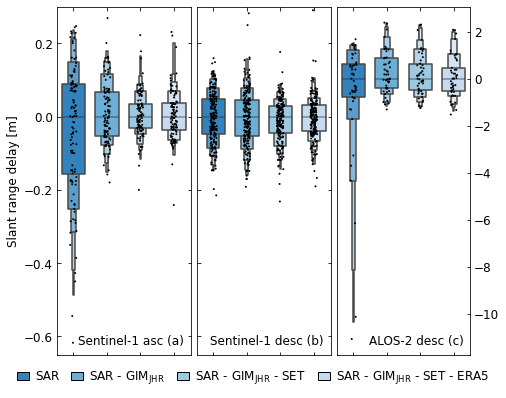

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[7, 5])
for ax, df in zip(axs, df_list):
    im = sns.boxenplot(ax=ax, data=df, k_depth='proportion', outlier_prop=0.05, showfliers=False,
                       orient='v', palette="tab20c", width=0.7, saturation=1)
    sns.stripplot(ax=ax, data=df, orient='v', size=2, color='k')

# axis format
for ax in axs:
    ax.set_xticklabels([])
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)
for ax in axs[:2]: ax.set_ylim(-0.65, 0.30)
axs[0].set_ylabel('Slant range delay [m]')
axs[1].set_yticklabels([])
axs[2].yaxis.tick_right()
axs[2].yaxis.set_label_position("right")
handles = [patches.Rectangle((0, 0), 1, 1, fc=plt.get_cmap('tab20c')(x), ec='k', lw=1) for x in [0, 1, 2, 3]]
labels = [r'SAR',
          r'SAR - GIM$_\mathrm{JHR}$',
          r'SAR - GIM$_\mathrm{JHR}$ - SET',
          r'SAR - GIM$_\mathrm{JHR}$ - SET - ERA5']
fig.tight_layout(pad=0.5)
fig.legend(handles=handles, labels=labels, ncol=4, loc='lower left', bbox_to_anchor=(0.01, -0.1), frameon=False, columnspacing=1, handlelength=1, handletextpad=0.5)

# label
for ax, label in zip(axs, ['Sentinel-1 asc (a)', 'Sentinel-1 desc (b)', 'ALOS-2 desc (c)']):
    ax.annotate(label, xy=(0.95, 0.03), xycoords='axes fraction', ha='right')

# output
out_fig = os.path.join(work_dir, 'box_stats.pdf')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()